In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 준비

In [19]:
df = pd.read_csv('vgames2.csv', sep =',', index_col=0)
df.reset_index(inplace=True)
df = df.drop('index',axis = 1)
df.tail()

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
16593,Ice Age 2: The Meltdown,GC,2006.0,Platform,Vivendi Games,0.15,0.04,0,0.01
16594,Rainbow Islands: Revolution,PSP,2005.0,Action,Rising Star Games,0.01,0,0,0
16595,NBA 2K16,PS3,2015.0,Sports,Take-Two Interactive,0.44,0.19,0.03,0.13
16596,Toukiden: The Age of Demons,PSV,2013.0,Action,Tecmo Koei,0.05,0.05,0.25,0.03
16597,The King of Fighters '95,PS,1996.0,Fighting,Sony Computer Entertainment,0,0,0.16,0.01


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         16598 non-null  object 
 1   Platform     16598 non-null  object 
 2   Year         16327 non-null  float64
 3   Genre        16548 non-null  object 
 4   Publisher    16540 non-null  object 
 5   NA_Sales     16598 non-null  object 
 6   EU_Sales     16598 non-null  object 
 7   JP_Sales     16598 non-null  object 
 8   Other_Sales  16598 non-null  object 
dtypes: float64(1), object(8)
memory usage: 1.1+ MB


In [4]:
df.isnull().sum()

Name             0
Platform         0
Year           271
Genre           50
Publisher       58
NA_Sales         0
EU_Sales         0
JP_Sales         0
Other_Sales      0
dtype: int64

# 데이터 전처리
1. Sales(판매량)의 단위가 일부는 M(million), K(thousand) 통일되어 있지 않음.
2. Year(출시년도)에 표현방식이 다르고, 결측치가 존재.
3. Genre에 결측치가 존재

## sales 전처리
- 처리 전 : million(m), thousand(k) 단위가 섞여 있음
- 처리 후: m으로 통일, global_sales 열을 새로 생성

In [5]:
# 함수 정의: sales cleaning
# 문자인 data type을 숫자(float)로 변경
# M이 있으면 제거, K가 있으면 제거 후 1000으로 나눔(단위변환)

def sales_cleaning(col):
    clean_sales = []
    for i in col:
        if 'K' in i:
            sale = float(i.replace('K','')) / 1000
            clean_sales.append(sale)
        elif 'M' in i:
            sale = float(i.replace('M',''))
            clean_sales.append(sale)
        else:
            sale = float(i)
            clean_sales.append(sale)
    return clean_sales

In [20]:
# 함수 적용해서 정리한 sales columns 만들기
sales = ['NA_Sales','EU_Sales', 'JP_Sales', 'Other_Sales']

df['NA_Sales'] = sales_cleaning(df['NA_Sales'])
df['EU_Sales'] = sales_cleaning(df['EU_Sales'])
df['JP_Sales'] = sales_cleaning(df['JP_Sales'])
df['Other_Sales'] = sales_cleaning(df['Other_Sales'])

In [21]:
df['Glo_Sales'] = df[sales].sum(axis=1)

- sales의 기술통계치와 분포 형태 

In [22]:
df[sales].describe()

,NA_Sales,EU_Sales,JP_Sales,Other_Sales
count,16598.000000,16598.000000,16598.000000,16598.000000
mean,0.264667,0.146652,0.077782,0.048063
std,0.816683,0.505351,0.309291,0.188588
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.080000,0.020000,0.000000,0.010000
75%,0.240000,0.110000,0.040000,0.040000
max,41.490000,29.020000,10.220000,10.570000


In [23]:
df[sales].skew()

NA_Sales       18.799627
EU_Sales       18.875535
JP_Sales       11.206458
Other_Sales    24.233923
dtype: float64

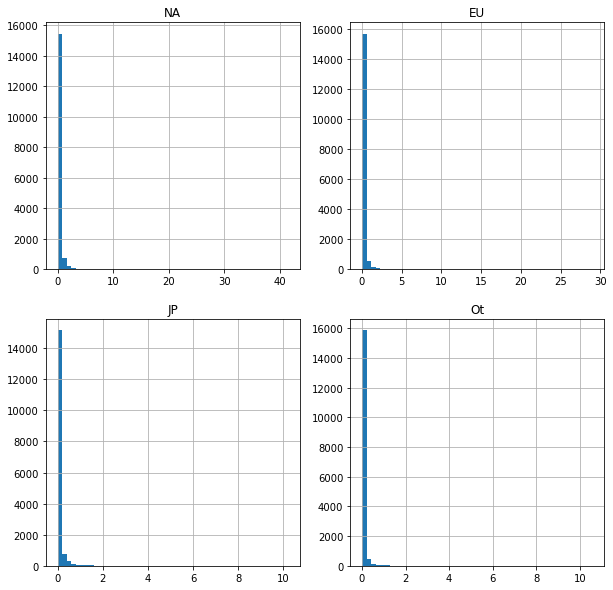

In [10]:
# 히스토그램으로 데이터 분포 보기 

plt.figure(figsize=(10,10))

plt.subplot(221)
plt.grid(True)
plt.title("NA")
plt.hist(df["NA_Sales"], bins=50)

plt.subplot(222)
plt.grid(True)
plt.title("EU")
plt.hist(df["EU_Sales"], bins=50)

plt.subplot(223)
plt.grid(True)
plt.title("JP")
plt.hist(df["JP_Sales"], bins=50)

plt.subplot(224)
plt.grid(True)
plt.title("Ot")
plt.hist(df["Other_Sales"], bins=50)

plt.show()

## Year 전처리

### 연도 형식 통일하기 
- 처리 전: 2002, 97, 2 형태로 값이 있음.
- 처리 후: 2002, 1997, 2002로 양식 통일 진행함. 

In [24]:
# 함수 정의: year cleaning

def year_cleaning(year):
    if np.isnan(year):                 # 결측치는 우선 pass
        pass
    else:        
        year = str(year).split('.')[0] 
        if len(year) == 1:             #연도에 숫자 하나만 있을 경우
            y = '200'+ year
            return int(y)
        if len(year) == 2:             #연도에 숫자 두개만 있을 경우
            y = int('20' + year)
            if y > 2080:               #1900년대 연도 변환
                y = y - 100
                return y
            else:
                return y                
        if len(year) == 4:             
            return int(year)
        else: 
            return int(year)

In [25]:
df['Year'] = df['Year'].apply(year_cleaning)

### 결측치(missing value) 처리(1)
- 처리 전: 게임이 플랫폼으로도 구별이 되어 있어 동일 게임이 여러개의 관측값을 가지고 있음.
- 처리 후: 271개의 missing value -> 147로 줄임

In [26]:
# year 값이 있는 것들만으로 df 후 Dictionary로 변경해서 일종의 db를 구축
df_year = df[~(df['Year'].isnull())][['Name','Year']]
db_game_year = df_year.set_index('Name').T.to_dict('records')[0]

# year가 nan인 행을 찾아, 그 행의 게임 name이 db에 있는지 파악해서 있으면 year 입력
mis_year_idx = df[df['Year'].isnull()].index

for i in mis_year_idx:
    name = df.iloc[i]['Name']
    try:
        if db_game_year[name]:
            df.at[i,'Year'] = db_game_year[name]
    except:
        pass

In [27]:
df.isnull().sum()

Name             0
Platform         0
Year           147
Genre           50
Publisher       58
NA_Sales         0
EU_Sales         0
JP_Sales         0
Other_Sales      0
Glo_Sales        0
dtype: int64

###  결측치(missing value) 처리(2)
- 처리 전: year가 결측치인 게임 중 일부는 그 판매량이 높음(1M 이상)
- 처리 후: 9개 게임은 직접 찾아 입력 결측치 147 -> 133, 133개 결측치는 제거 예정


In [28]:
# year가 결측치인 게임들의 판매량을 검토함. 
df_noy_sales = df[(df['Year'].isnull())].groupby('Name').Glo_Sales.sum().\
               to_frame()
df_noy_sales

,Glo_Sales
Name,
Action Man-Operation Extreme,0.09
Advance Wars: Days of Ruin,0.63
Adventure,1.30
Agarest Senki: Re-appearance,0.01
Air-Sea Battle,0.98
...,...
Yu Yu Hakusho: Dark Tournament,0.21
Yu-Gi-Oh! 5D's Wheelie Breakers (JP sales),0.02
Zero: Tsukihami no Kamen,0.08


In [30]:
# 판매량이 높은 순서로 게임을 정렬함. 
# 일부 게임은 무시하기에 판매량이 매우 크다는 걸 알 수 있음. 
df_noy_sales.Glo_Sales.sort_values(ascending = False)[:10]

Name
Rock Band                                   7.33
wwe Smackdown vs. Raw 2006                  3.00
Frogger's Adventures: Temple of the Frog    2.40
Test Drive Unlimited 2                      1.52
Triple Play 99                              1.46
Adventure                                   1.30
Combat                                      1.25
Legacy of Kain: Soul Reaver                 1.05
Donkey Kong Land III                        1.03
Air-Sea Battle                              0.98
Name: Glo_Sales, dtype: float64

In [31]:
# 1M이 넘는 게임은 직접 찾아 입력

find_year = {'Adventure': 1980,
 'Combat': 1974,
 'Donkey Kong Land III':1997,
 "Frogger's Adventures: Temple of the Frog": 2001,
 'Legacy of Kain: Soul Reaver': 1999,
 'Rock Band':2007,
 'Test Drive Unlimited 2':2011,
 'Triple Play 99':1998,
 'wwe Smackdown vs. Raw 2006':2005}

db_game_year.update(find_year) # 위에서 만든 db에 업데이트 후 게임 이름이 해당 db에 있으면 입력

for i in list(df[df['Year'].isnull()].index):
    name = df.iloc[i]['Name']
    try:
        if db_game_year[name]:
            df.at[i,'Year'] = db_game_year[name]
    except:
        pass

In [32]:
df.isnull().sum()

Name             0
Platform         0
Year           133
Genre           50
Publisher       58
NA_Sales         0
EU_Sales         0
JP_Sales         0
Other_Sales      0
Glo_Sales        0
dtype: int64

## 장르 결측치 처리
### 결측치 처리 (1)

- 처리 전: 같은 이름의 게임 중 일부가 결측치로 되어 있음.
- 처리 후: 결측치 50 -> 30

In [35]:
# genre 값이 있는 것들만으로 df 후 Dictionary로 변경해서 일종의 db를 구축
df_genre = df[~(df['Genre'].isnull())][['Name','Genre']]
db_game_genre = df_genre.set_index('Name').T.to_dict('records')[0]

# genre가 nan인 행을 찾아, 그 행의 게임 name이 db에 있는지 파악해서 있으면 genre 입력

mis_genre_idx = df[df['Genre'].isnull()].index
for i in mis_genre_idx:
    name = df.iloc[i]['Name']
    try:
        if db_game_genre[name]:
            df.at[i,'Genre'] = db_game_genre[name]
    except:
        pass

In [36]:
df.isnull().sum()

Name               0
Platform           0
Year             133
Genre             30
Publisher         58
NA_Sales           0
EU_Sales           0
JP_Sales           0
Other_Sales        0
Glo_Sales          0
C_genre        16578
dtype: int64

### 결측치 처리 (2)
- 처리 전: Genre가 결측치인 일부 게임의 판매량이 높음
- 처리 후: 1M이 넘는 게임은 직접 찾아 채움 결측치 30 -> 22

In [44]:
df[df['Genre'].isnull()].groupby('Name').Glo_Sales.sum().sort_values(ascending=False)

Name
Pokemon X/Pokemon Y                         14.35
Wii Party                                    8.49
Final Fantasy XII                            5.95
Onimusha: Warlords                           2.70
Bloodborne                                   2.38
Chrono Cross                                 1.85
Yakuza 3                                     1.12
F-Zero X                                     1.10
WarioWare, Inc.: Mega Party Game$            0.71
Ape Escape: On the Loose                     0.70
SingStar Singalong With Disney               0.61
NASCAR Racing                                0.42
Puppy Palace                                 0.38
The Godfather: Dons Edition                  0.30
Jurassic Park III: Island Attack             0.18
Brain Boost: Beta Wave                       0.15
Brain Quest: Grades 5 & 6                    0.12
Urban Chaos                                  0.11
Virtual Chess 64                             0.06
Myth Makers: Orbs of Doom                    

In [46]:
#year에서 1M을 기준으로 삼은 것처럼 장르도 1M이 넘는 게임만 찾아서 데이터를 보완해보자. 
db_find_genre = {'Pokemon X/Pokemon Y' : 'Role-Playing',
              'Wii Party' : 'Misc',
              'Final Fantasy XII' : 'Role-Playing',
              'Onimusha: Warlords': "Action",
              'Bloodborne' : 'Action',
              'Chrono Cross': 'Action',
              'Yakuza 3': 'Action',
              'F-Zero X': 'Racing'
}
for i in df['Genre'].isnull().index:
    name = df.iloc[i]['Name']
    try:
        if db_find_genre[name]:
            df.at[i,'Genre'] = db_find_genre[name]
    except:
        pass

In [47]:
df.isnull().sum()

Name             0
Platform         0
Year           133
Genre           22
Publisher       58
NA_Sales         0
EU_Sales         0
JP_Sales         0
Other_Sales      0
Glo_Sales        0
dtype: int64

## 전처리 1차 완료
- year, genre 결측치는 모두 제거하고 별도 dataframe을 파일로 저장

In [49]:
df = df.dropna(subset=['Year','Genre'])
df.tail()

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Glo_Sales
16593,Ice Age 2: The Meltdown,GC,2006.0,Platform,Vivendi Games,0.15,0.04,0.00,0.01,0.20
16594,Rainbow Islands: Revolution,PSP,2005.0,Action,Rising Star Games,0.01,0.00,0.00,0.00,0.01
16595,NBA 2K16,PS3,2015.0,Sports,Take-Two Interactive,0.44,0.19,0.03,0.13,0.79
16596,Toukiden: The Age of Demons,PSV,2013.0,Action,Tecmo Koei,0.05,0.05,0.25,0.03,0.38
16597,The King of Fighters '95,PS,1996.0,Fighting,Sony Computer Entertainment,0.00,0.00,0.16,0.01,0.17


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16443 entries, 0 to 16597
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         16443 non-null  object 
 1   Platform     16443 non-null  object 
 2   Year         16443 non-null  float64
 3   Genre        16443 non-null  object 
 4   Publisher    16399 non-null  object 
 5   NA_Sales     16443 non-null  float64
 6   EU_Sales     16443 non-null  float64
 7   JP_Sales     16443 non-null  float64
 8   Other_Sales  16443 non-null  float64
 9   Glo_Sales    16443 non-null  float64
dtypes: float64(6), object(4)
memory usage: 1.4+ MB


In [ ]:
# 1974(1개 게임), 2017(2개 게임), 2020(1개) 로 

In [51]:
# 파일 저장
df.to_csv('vgames2_cleaned', sep =',', index = False)